Load Python Libraries

In [1]:
Version: 1.2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
import matplotlib.dates as mdates
%matplotlib inline

Import PV Data. PV Data's format has 5 columns, with 2nd column representing the kW output of each hourly period, 1st column: DateTime

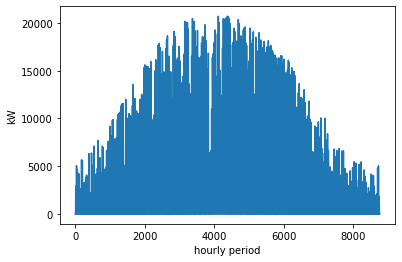

Annual Solar Generation: 29038642.67 kWh
8760


In [2]:
# import data
solar_profile = pd.read_csv("C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/Data/OxfordSolar30MWhourlyFull.csv", usecols=[1]).values

# plot data
plt.plot(solar_profile)  # just plotting a single day from the entire year
plt.ylabel("kW")
plt.xlabel("hourly period")
plt.show()

# calculate annual generation
print("Annual Solar Generation: {:.2f} kWh".format(solar_profile.sum()))
 
print(len(solar_profile))

Create Electrolyzer Class and Location Class


In [3]:
class electrolyzer:
    def __init__(self,production_rate,install_cost,max_power,min_power_percentage, lifetime):
        self.production_rate = production_rate     #kg of hydrogen produced per second per MW of electricity
        self.install_cost = install_cost           #in GBP
        self.max_power = max_power                 #in MW
        self.min_power = max_power*min_power_percentage/100  # in MW, minimum power to retain its ability to ramp up and down quickly  
        self.lifetime = lifetime                   #in hours
    
class location:
    def __init__(self, var_waterprice, fixed_waterprice,elec_price):
        self.var_waterprice = var_waterprice               # price per m3
        self.fixed_waterprice = fixed_waterprice           # price per day 
        self.elec_price = elec_price                       #GBP Per MWh
        
class energysystem: 
    def __init__(self,location,electrolyzer):
        self.location = location
        self.electrolyzer = electrolyzer
        

    
  #  def CapEx(self): 
   #     CapEx = self.location.fixed_waterprice + self.electrolyzer.install_cost
    #    return CapEx 
        
    #def OpEx:   #water and electricity costs per kg of hydrogen 
        
    #    return OpEx

ITM HGas3SP Electrolyzer created below

In [4]:
itm_H3GSP = electrolyzer(0.01/2.35, 3090000, 2.35,10,50000)
NEL_A3880 = electrolyzer(0.0958/17.072, 15129974.64, 17.072, 15,65000)
Oxford = location(1.4570,(17.84/30),160.3)
test1 = energysystem(Oxford,itm_H3GSP)
test2 = energysystem(Oxford,NEL_A3880)

test1.location.fixed_waterprice

0.5946666666666667

In [5]:
Power = solar_profile*0.001                   #Average power(MW) of solar grid in the hourly period


Theoretical Electrolyzer Power Output in each hour period <br>
(Taking into account max rate of change of power) <br>
(Without taking into account max and min power)

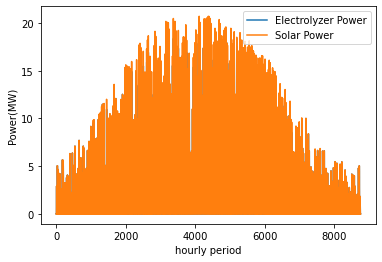

In [6]:
T = len(Power)                           # no. of hourly periods
grid_demand = np.zeros((T,1))            # power required from grid 
H_produced = np.zeros((T,1))             # kg of hydrogen produced in the hour period


# solar power change compared to  previous hour period
p_change = np.zeros((T,1))               
for j in range(T):
    if j == 0: 
        p_change[j] = 0
    else: 
        p_change[j] = Power[j] - Power[j-1]

# for this test, we will set max power change of electrolyzer to be 2e-4 MW per hour
max_p_change = 2

needed_p_change = np.zeros((T,1))            # power change needed for electrolyzer
electrolyzer_power = np.zeros((T,1))

for j in range(T):
    if j == 0:
        electrolyzer_power[j] = Power[j]
        needed_p_change[j] = 0
    else: 
        needed_p_change[j] = Power[j] - electrolyzer_power[j-1]
    
    if abs(needed_p_change[j]) > max_p_change:      #if electrolyzer cannot handle power change
        electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*max_p_change
        
    elif abs(needed_p_change[j]) <= max_p_change:   #if electrolyzer can handle power change
        if electrolyzer_power[j-1] == Power[j-1]:      # if electrolyzer is handling it well
            electrolyzer_power[j] = Power[j]
        elif electrolyzer_power[j-1] != Power[j-1]:     # if electrolyzer was not in sync with solar power 
            electrolyzer_power[j] = electrolyzer_power[j-1] + np.sign(needed_p_change[j])*min(abs(max_p_change),abs(needed_p_change[j]))
            
ax = plt.subplot(1,1,1)
plt.plot(electrolyzer_power, label = 'Electrolyzer Power')
plt.plot(Power, label = 'Solar Power')
plt.xlabel('hourly period')
plt.ylabel('Power(MW)')

ax.legend()


Battery

In [7]:
batt_power = np.zeros((T,1))
H_from_batt = np.zeros((T,1))

Hydrogen produced in each hourly period <br>
(Taking into account max and min power) <br>
Cost of electricity if electrolyzer takes electricity from grid <br>
Cost of water  <br>
CO2 emissions from grid electricity<br>
Assuming electrolyser is powered by solar power by default: CO2 emissions of solar power

In [15]:
# electrolyzer takes electricity from grid, if solar power falls below min power 
# assume solar power is free 

electrolyser = NEL_A3880
# Records hydrogen produced in each hour period
for j in range(T):
    if electrolyzer_power[j] > electrolyser.max_power:                  #if theoretical power exceeds max power
        H_produced[j] = electrolyser.max_power*electrolyser.production_rate*60*60 
        batt_power[j] = electrolyzer_power[j] - electrolyser.max_power
    elif electrolyzer_power[j] >= electrolyser.min_power:               #if theoretical power is within acceptable range      
        H_produced[j] = electrolyzer_power[j]*electrolyser.production_rate*60*60
    else:                                                               #if theoretical power is below min power
        H_produced[j] = electrolyser.min_power*electrolyser.production_rate*60*60
        grid_demand[j] = electrolyser.min_power - electrolyzer_power[j] 

print('Max Battery Power Rating needed(in MW) is')
print(max(batt_power))

H_from_batt = batt_power*electrolyser.production_rate*60*60

print('Hydrogen produced(in kg) is')
print(sum(H_from_batt))

Max Battery Power Rating needed(in MW) is
[2.05113457]
Hydrogen produced(in kg) is
[841.52871968]


Electrolyser is only switched on during certain hours

In [19]:
for i in range(119):
    H_produced[0+i*24:6+i*24] =0
    H_produced[17+i*24:23+i*24] =0
    grid_demand[0+i*24:6+i*24] = 0
    grid_demand[17+i*24:23+i*24] = 0
    electrolyzer_power[0+i*24:6+i*24]= 0
    electrolyzer_power[17+i*24:23+i*24]= 0
    
for i in range(120,239):
    H_produced[0+i*24:4+i*24] =0
    H_produced[20+i*24:23+i*24] =0
    grid_demand[0+i*24:4+i*24]= 0
    grid_demand[20+i*24:23+i*24]= 0
    electrolyzer_power[0+i*24:4+i*24] = 0
    electrolyzer_power[20+i*24:23+i*24] = 0
    
for i in range(240,364):
    H_produced[0+i*24:6+i*24] =0
    H_produced[17+i*24:23+i*24] = 0
    grid_demand[0+i*24:6+i*24] = 0
    grid_demand[17+i*24:23+i*24] = 0
    electrolyzer_power[0+i*24:6+i*24]= 0
    electrolyzer_power[17+i*24:23+i*24]= 0
    

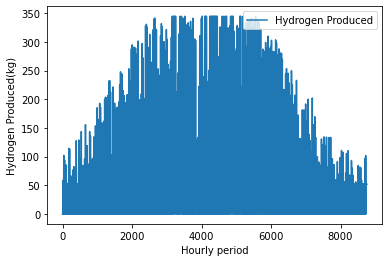

In [20]:
ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Hydrogen Produced')
plt.xlabel('Hourly period')
plt.ylabel('Hydrogen Produced(kg)')

ax.legend()


CO2 emissions and operating costs

In [21]:
#Solar Power needed in each hour
solar_power = np.zeros((T,1))
co2persolar = 0                                         #gCO2e per kWh
for j in range(T):
    if electrolyzer_power[j] > electrolyser.max_power:                  #if theoretical power exceeds max power
        solar_power[j] = electrolyser.max_power
    else:
        solar_power[j] = electrolyzer_power[j]

solar_co2_emissions = sum(solar_power*co2persolar*1000)       #in grams

co2perelec = 256                                               #gCO2e per kWh
grid_co2_emissions = sum(grid_demand*co2perelec*1000)          #in grams


print('Total co2 emissions from electricity is')
print(solar_co2_emissions+grid_co2_emissions)


Total_elec_cost =sum(grid_demand* Oxford.elec_price)
print('Total cost of grid electricity consumption is')
print(Total_elec_cost)

Water_consumption = 9                                         #kg of water needed for each kg of hydrogen

Total_water_price = T*Oxford.fixed_waterprice + sum(H_produced*Water_consumption*Oxford.var_waterprice)

print('Total cost of water consumption is')
print(Total_water_price)

Total co2 emissions from electricity is
[8.83722553e+08]
Total cost of grid electricity consumption is
[553362.20801974]
Total cost of water consumption is
[8123321.63346636]


Daily Hydrogen Production throughout the year 

Total hydrogen produced (in kg) is
[619088.87008813]


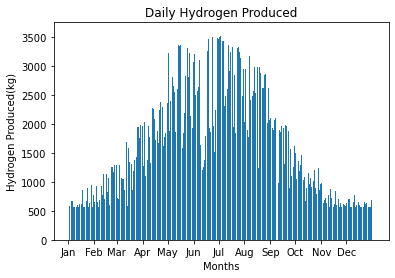

In [22]:
No_of_days = T/24
No_of_days = int(No_of_days)
daily_H2_pd = np.zeros((No_of_days))
for i in range(int(No_of_days)):
    daily_H2_pd[i] = sum(H_produced[(0 + i*24):(23 + i*24)])

ax = plt.subplot(1,1,1)

#plt.plot(daily_H2_pd, label = 'Daily Hydrogen Produced')
daysNum = len(daily_H2_pd)
daySet = np.arange(1,daysNum+1)
plt.bar(daySet,daily_H2_pd)
plt.title("Daily Hydrogen Produced")
plt.xticks([0,31,58,89,119,150,180,211,242,272,303,333])
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Months')
plt.ylabel('Hydrogen Produced(kg)')

total_annual_hydrogen = sum(H_produced)
print('Total hydrogen produced (in kg) is')
print(total_annual_hydrogen)

Reverse Engineer actual electrolyzer power 

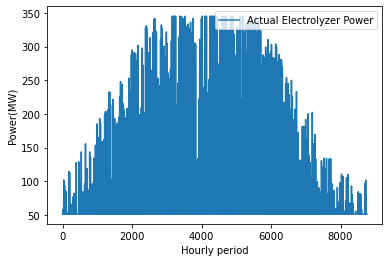

In [11]:
actual_electrolyzer_power = H_produced / electrolyser.production_rate

ax = plt.subplot(1,1,1)
plt.plot(H_produced, label = 'Actual Electrolyzer Power')
plt.xlabel('Hourly period')
plt.ylabel('Power(MW)')

ax.legend()

Code for Hydrogen Storage

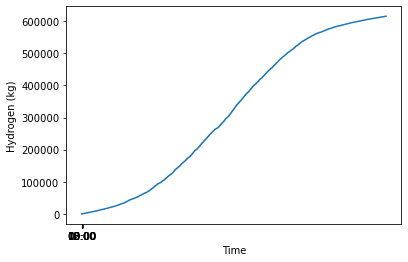

In [12]:
hydrogen_capacity = 10  # kg

T = len(solar_profile)                    # no. of half hour periods
outputi = np.zeros((T,1))  # hydrogen production flow
soc = np.zeros((T,1))  # weight of hydrogen stored


for j in range(T):
    if j == 0:
        socval = 0 
    else:
        socval = soc[j-1]                 #stores soc from the previous timeslot
    
    # if there is production of hydrogen
    if Power[j] > 0:      
        outputi[j] = H_produced[j]
        soc[j] = socval + outputi[j]     #battery is being discharged so soc decreases
        
    # if there is no production of hydrogen
    elif solar_profile[j] == 0: 
        soc[j] = socval                     # battery soc has no change

        
ax = plt.subplot(1,1,1)
p = plt.plot(soc)

plt.xticks([0,6,12,18,24])
ax.set_xticklabels(['00:00','06:00','12:00','18:00','00:00'])
plt.ylabel('Hydrogen (kg)', color='k')
plt.xlabel('Time', color='k')
plt.show()

Converts array into csv

In [13]:
pd.DataFrame(daily_H2_pd).to_csv(r'C:/Users/tangl/OneDrive/Engineering Course/Year 3/3YP/data.csv',index = False)

Net Present Cost of electrolyser <br>
Assuming a yearly depreciation to a value of zero at the end of the lifetime<br>
Lifetime of electrolyser is depleted for each non-zero output 

In [14]:
electrolyser = NEL_A3880
lifetime = electrolyser.lifetime
print(lifetime)
discount_rate = 0.0025
operating_hours = np.count_nonzero(H_produced)
years_lifetime = np.round(lifetime/operating_hours)
years_lifetime = int(years_lifetime)
print(years_lifetime)
annual_cost = electrolyser.install_cost/years_lifetime

cost = np.zeros((years_lifetime,1))   
for j in range(years_lifetime):
    cost[j] = annual_cost *((1-discount_rate)**j)
    
npv = sum(cost)

65000
7


In [15]:
print(npv)

[15016971.4616498]


SyntaxError: invalid syntax (<ipython-input-53-377231b74f63>, line 1)